In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipaddress import ip_address
credit_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\creditcard.csv')
fraud_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\Fraud_Data.csv')
ip_df =  pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\IpAddress_to_Country.csv')
# Check missing values
print("Missing values:\n", fraud_df.isnull().sum())
print(fraud_df.columns)

# Drop rows with missing values (you can also impute if appropriate)
fraud_df.dropna(inplace=True)


Missing values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')


In [12]:
# Remove duplicates
fraud_df.drop_duplicates(inplace=True)

# Convert datetime columns
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Convert categorical types
fraud_df['sex'] = fraud_df['sex'].astype('category')
fraud_df['source'] = fraud_df['source'].astype('category')
fraud_df['browser'] = fraud_df['browser'].astype('category')


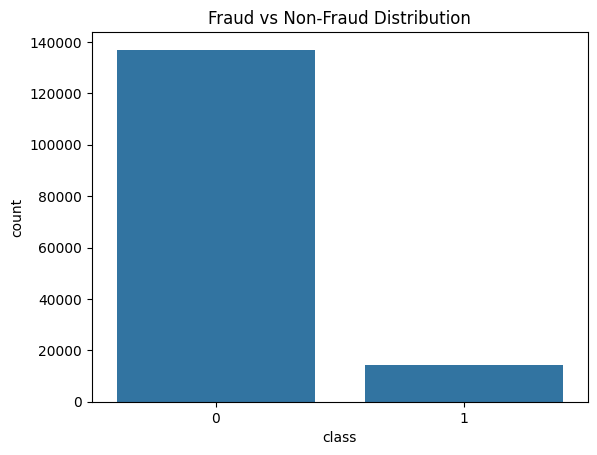

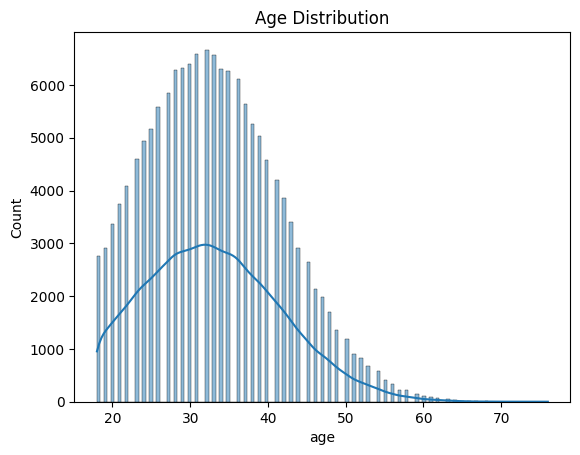

In [13]:
# Class distribution
sns.countplot(x='class', data=fraud_df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

# Age distribution
sns.histplot(fraud_df['age'], kde=True)
plt.title("Age Distribution")
plt.show()


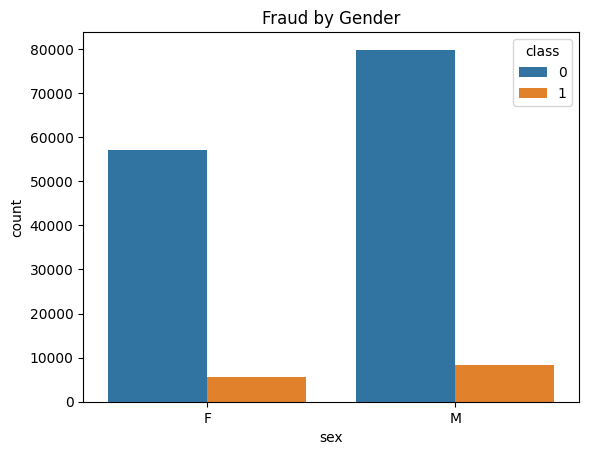

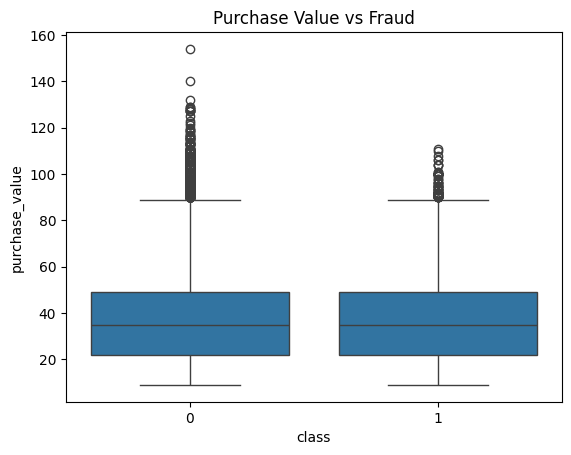

In [14]:
# Fraud by gender
sns.countplot(x='sex', hue='class', data=fraud_df)
plt.title("Fraud by Gender")
plt.show()

# Purchase value by fraud status
sns.boxplot(x='class', y='purchase_value', data=fraud_df)
plt.title("Purchase Value vs Fraud")
plt.show()


In [29]:
def ip_to_int(ip_str):
    try:
        return int(ip_address(ip_str))
    except:
        return np.nan
print(ip_df.columns)

fraud_df.dropna(subset=['ip_int'], inplace=True)
ip_df.dropna(inplace=True)
ip_df.drop_duplicates(inplace=True)

ip_df = ip_df.sort_values('lower_bound_ip_int')
fraud_df = fraud_df.sort_values('ip_int')

ip_right = ip_df[['lower_bound_ip_int', 'upper_bound_ip_int', 'country']].rename(
    columns={
        'lower_bound_ip_int': 'ip_lower_bound',
        'upper_bound_ip_int': 'ip_upper_bound',
        'country': 'ip_country'
    }
)

fraud_df = pd.merge_asof(
    fraud_df,
    ip_right,
    left_on='ip_int',
    right_on='ip_lower_bound',
    direction='backward'
)

fraud_df = fraud_df[fraud_df['ip_int'] <= fraud_df['ip_upper_bound']]


Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country',
       'lower_bound_ip_int', 'upper_bound_ip_int'],
      dtype='object')


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
fraud_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\Fraud_Data.csv')
credit_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\creditcard.csv')

X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']
X_credit = credit_df.drop('Class', axis=1)
y_credit = credit_df['Class']
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

fraud_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\Fraud_Data.csv')

fraud_df.dropna(inplace=True)

fraud_df.drop_duplicates(inplace=True)

fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['signup_dayofweek'] = fraud_df['signup_time'].dt.dayofweek
fraud_df['purchase_dayofweek'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_diff'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

fraud_df = fraud_df.drop(['signup_time', 'purchase_time'], axis=1)

fraud_df = pd.get_dummies(fraud_df, columns=['sex', 'source', 'browser'], drop_first=True)

X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']


X_fraud = X_fraud.apply(pd.to_numeric, errors='coerce')

X_fraud = X_fraud.fillna(0)


X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

scaler = StandardScaler()
X_fraud_train = scaler.fit_transform(X_fraud_train)
X_fraud_test = scaler.transform(X_fraud_test)


log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_fraud_train, y_fraud_train)
y_pred_lr = log_reg.predict(X_fraud_test)

print("\nLogistic Regression Results (Fraud_Data)")
print(classification_report(y_fraud_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_fraud_test, y_pred_lr))


rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_fraud_train, y_fraud_train)
y_pred_rf = rf.predict(X_fraud_test)

print("\nRandom Forest Results (Fraud_Data)")
print(classification_report(y_fraud_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_fraud_test, y_pred_rf))

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=10,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_fraud_train, y_fraud_train)
y_pred_xgb = xgb.predict(X_fraud_test)

print("\nXGBoost Results (Fraud_Data)")
print(classification_report(y_fraud_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_fraud_test, y_pred_xgb))



Logistic Regression Results (Fraud_Data)
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     27393
           1       0.17      0.70      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223

ROC-AUC Score: 0.6678703671813193

Random Forest Results (Fraud_Data)
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

ROC-AUC Score: 0.7634093089991394


c:\Users\Amenzz\Desktop\week8\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Results (Fraud_Data)
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.88      0.53      0.66      2830

    accuracy                           0.95     30223
   macro avg       0.92      0.76      0.82     30223
weighted avg       0.95      0.95      0.94     30223

ROC-AUC Score: 0.7617204570717107


In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

fraud_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\creditcard.csv')

fraud_df.dropna(inplace=True)

fraud_df.drop_duplicates(inplace=True)

fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['signup_dayofweek'] = fraud_df['signup_time'].dt.dayofweek
fraud_df['purchase_dayofweek'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_diff'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

fraud_df = fraud_df.drop(['signup_time', 'purchase_time'], axis=1)

fraud_df = pd.get_dummies(fraud_df, columns=['sex', 'source', 'browser'], drop_first=True)

X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']


X_fraud = X_fraud.apply(pd.to_numeric, errors='coerce')

X_fraud = X_fraud.fillna(0)


X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

scaler = StandardScaler()
X_fraud_train = scaler.fit_transform(X_fraud_train)
X_fraud_test = scaler.transform(X_fraud_test)


log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_fraud_train, y_fraud_train)
y_pred_lr = log_reg.predict(X_fraud_test)

print("\nLogistic Regression Results (Fraud_Data)")
print(classification_report(y_fraud_test, y_pred_lr))
print("ROC-AUC Score:", roc_auc_score(y_fraud_test, y_pred_lr))


rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_fraud_train, y_fraud_train)
y_pred_rf = rf.predict(X_fraud_test)

print("\nRandom Forest Results (Fraud_Data)")
print(classification_report(y_fraud_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_fraud_test, y_pred_rf))

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=10,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_fraud_train, y_fraud_train)
y_pred_xgb = xgb.predict(X_fraud_test)

print("\nXGBoost Results (Fraud_Data)")
print(classification_report(y_fraud_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_fraud_test, y_pred_xgb))

In [ ]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# Load dataset
fraud_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\Fraud_Data.csv')

# Handle missing values and duplicates
fraud_df.dropna(inplace=True)
fraud_df.drop_duplicates(inplace=True)

# Convert datetime columns
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Feature engineering (datetime features)
fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['signup_dayofweek'] = fraud_df['signup_time'].dt.dayofweek
fraud_df['purchase_dayofweek'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_diff'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

# Drop original datetime columns
fraud_df = fraud_df.drop(['signup_time', 'purchase_time'], axis=1)

# Encode categorical features
fraud_df = pd.get_dummies(fraud_df, columns=['sex', 'source', 'browser'], drop_first=True)

# Separate features and target
X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']

# Convert all to numeric and handle NaNs
X_fraud = X_fraud.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train-test split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

# Scale features
scaler_fraud = StandardScaler()
X_fraud_train = scaler_fraud.fit_transform(X_fraud_train)
X_fraud_test = scaler_fraud.transform(X_fraud_test)


log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_fraud_train, y_fraud_train)
y_pred_lr = log_reg.predict(X_fraud_test)

print("\n=== Logistic Regression (Fraud_Data) ===")
print(classification_report(y_fraud_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_fraud_test, y_pred_lr))

rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_fraud_train, y_fraud_train)
y_pred_rf = rf.predict(X_fraud_test)

print("\n=== Random Forest (Fraud_Data) ===")
print(classification_report(y_fraud_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_fraud_test, y_pred_rf))

xgb = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=6,
    scale_pos_weight=10, random_state=42,
    use_label_encoder=False, eval_metric='logloss'
)
xgb.fit(X_fraud_train, y_fraud_train)
y_pred_xgb = xgb.predict(X_fraud_test)

print("\n=== XGBoost (Fraud_Data) ===")
print(classification_report(y_fraud_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_fraud_test, y_pred_xgb))



# Load dataset
credit_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\creditcard.csv')

# Handle missing values and duplicates
credit_df.dropna(inplace=True)
credit_df.drop_duplicates(inplace=True)

# Separate features and target
X_credit = credit_df.drop('Class', axis=1)
y_credit = credit_df['Class']

# Convert all to numeric and handle NaNs (should already be numeric, but for safety)
X_credit = X_credit.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train-test split
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)

# Scale features
scaler_credit = StandardScaler()
X_credit_train = scaler_credit.fit_transform(X_credit_train)
X_credit_test = scaler_credit.transform(X_credit_test)

log_reg2 = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg2.fit(X_credit_train, y_credit_train)
y_pred_lr2 = log_reg2.predict(X_credit_test)

print("\n=== Logistic Regression (CreditCard) ===")
print(classification_report(y_credit_test, y_pred_lr2))
print("ROC-AUC:", roc_auc_score(y_credit_test, y_pred_lr2))

rf2 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf2.fit(X_credit_train, y_credit_train)
y_pred_rf2 = rf2.predict(X_credit_test)

print("\n=== Random Forest (CreditCard) ===")
print(classification_report(y_credit_test, y_pred_rf2))
print("ROC-AUC:", roc_auc_score(y_credit_test, y_pred_rf2))


xgb2 = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=6,
    scale_pos_weight=10, random_state=42,
    use_label_encoder=False, eval_metric='logloss'
)
xgb2.fit(X_credit_train, y_credit_train)
y_pred_xgb2 = xgb2.predict(X_credit_test)

print("\n=== XGBoost (CreditCard) ===")
print(classification_report(y_credit_test, y_pred_xgb2))
print("ROC-AUC:", roc_auc_score(y_credit_test, y_pred_xgb2))



=== Logistic Regression (Fraud_Data) ===
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     27393
           1       0.17      0.70      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223

ROC-AUC: 0.6678703671813193

=== Random Forest (Fraud_Data) ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

ROC-AUC: 0.7634093089991394


c:\Users\Amenzz\Desktop\week8\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:10:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost (Fraud_Data) ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.88      0.53      0.66      2830

    accuracy                           0.95     30223
   macro avg       0.92      0.76      0.82     30223
weighted avg       0.95      0.95      0.94     30223

ROC-AUC: 0.7617204570717107

=== Logistic Regression (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746

ROC-AUC: 0.9245828335821638

=== Random Forest (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.72      0.82        95

    accuracy      

c:\Users\Amenzz\Desktop\week8\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:16:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.94      0.76      0.84        95

    accuracy                           1.00     56746
   macro avg       0.97      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746

ROC-AUC: 0.8789032385733889


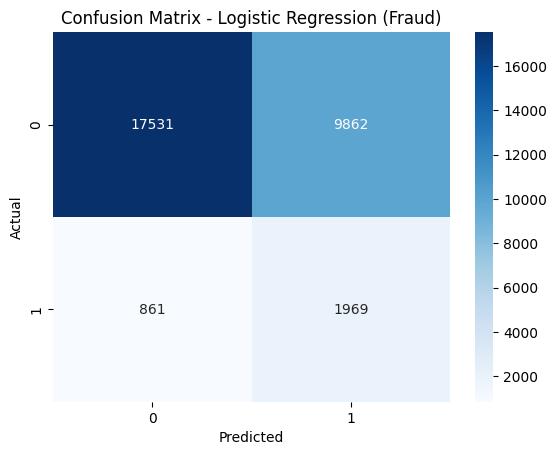


=== Logistic Regression (Fraud) ===
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     27393
           1       0.17      0.70      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223

ROC-AUC: 0.6678703671813193
AUC-PR: 0.4397383746433071


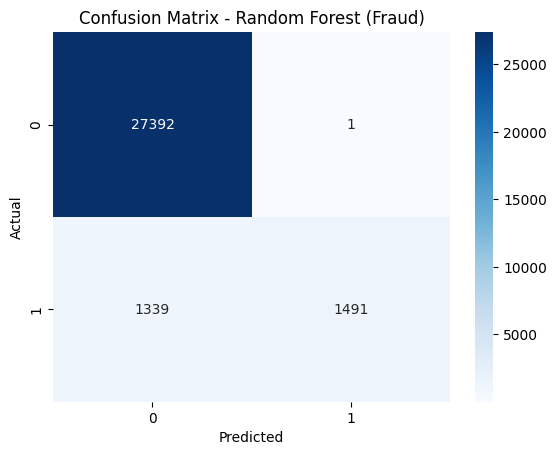


=== Random Forest (Fraud) ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

ROC-AUC: 0.7634093089991394
AUC-PR: 0.6239996614917793


c:\Users\Amenzz\Desktop\week8\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:38:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


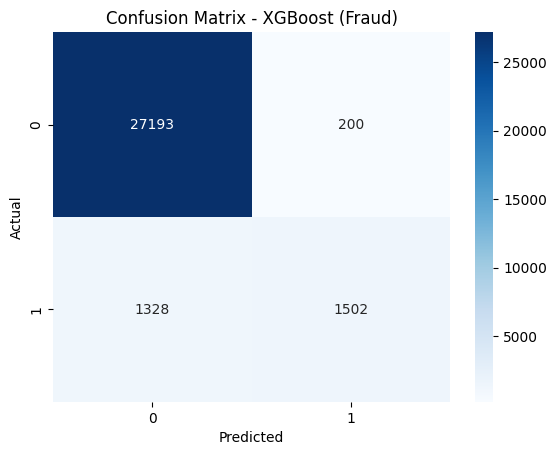


=== XGBoost (Fraud) ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.88      0.53      0.66      2830

    accuracy                           0.95     30223
   macro avg       0.92      0.76      0.82     30223
weighted avg       0.95      0.95      0.94     30223

ROC-AUC: 0.7617204570717107
AUC-PR: 0.6184528921733911


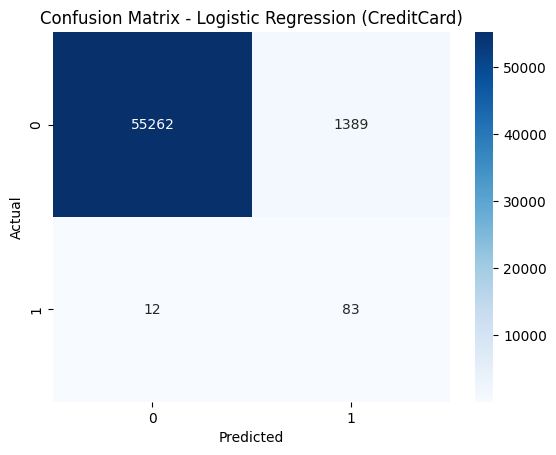


=== Logistic Regression (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746

ROC-AUC: 0.9245828335821638
AUC-PR: 0.7046147290782282


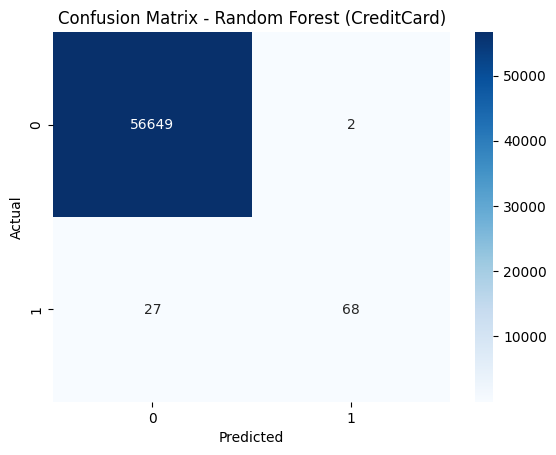


=== Random Forest (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.72      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746

ROC-AUC: 0.8578770849030397
AUC-PR: 0.8145489698427055


c:\Users\Amenzz\Desktop\week8\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


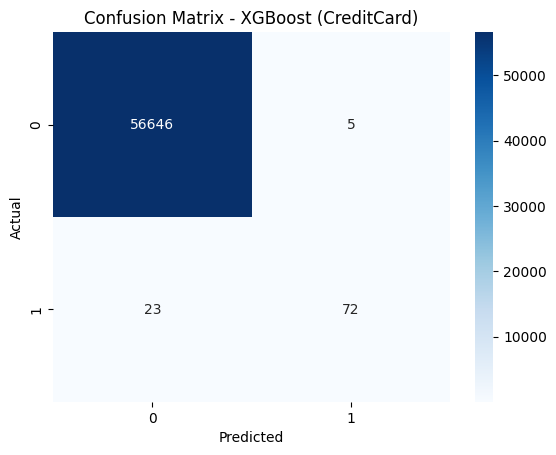


=== XGBoost (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.94      0.76      0.84        95

    accuracy                           1.00     56746
   macro avg       0.97      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746

ROC-AUC: 0.8789032385733889
AUC-PR: 0.8079383570024813


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred, y_proba):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # AUC-PR
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    auc_pr = auc(recall, precision)

    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    print("AUC-PR:", auc_pr)

fraud_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\Fraud_Data.csv')

# Handle missing values & duplicates
fraud_df.dropna(inplace=True)
fraud_df.drop_duplicates(inplace=True)

# Datetime conversion
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Feature engineering
fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['signup_dayofweek'] = fraud_df['signup_time'].dt.dayofweek
fraud_df['purchase_dayofweek'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_diff'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()

fraud_df.drop(['signup_time', 'purchase_time'], axis=1, inplace=True)

# Encode categorical
fraud_df = pd.get_dummies(fraud_df, columns=['sex', 'source', 'browser'], drop_first=True)

# Split features/target
X_fraud = fraud_df.drop('class', axis=1).apply(pd.to_numeric, errors='coerce').fillna(0)
y_fraud = fraud_df['class']

# Train-test split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

# Scaling
scaler_fraud = StandardScaler()
X_fraud_train = scaler_fraud.fit_transform(X_fraud_train)
X_fraud_test = scaler_fraud.transform(X_fraud_test)

# Models
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, scale_pos_weight=10,
                    random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train & Evaluate
for model, name in [(log_reg, "Logistic Regression (Fraud)"),
                    (rf, "Random Forest (Fraud)"),
                    (xgb, "XGBoost (Fraud)")]:
    model.fit(X_fraud_train, y_fraud_train)
    y_pred = model.predict(X_fraud_test)
    y_proba = model.predict_proba(X_fraud_test)[:,1]
    evaluate_model(name, y_fraud_test, y_pred, y_proba)

credit_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\creditcard.csv')

# Handle missing values & duplicates
credit_df.dropna(inplace=True)
credit_df.drop_duplicates(inplace=True)

# Split features/target
X_credit = credit_df.drop('Class', axis=1).apply(pd.to_numeric, errors='coerce').fillna(0)
y_credit = credit_df['Class']

# Train-test split
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)

# Scaling
scaler_credit = StandardScaler()
X_credit_train = scaler_credit.fit_transform(X_credit_train)
X_credit_test = scaler_credit.transform(X_credit_test)

# Models
log_reg2 = LogisticRegression(max_iter=1000, class_weight='balanced')
rf2 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
xgb2 = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, scale_pos_weight=10,
                     random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train & Evaluate
for model, name in [(log_reg2, "Logistic Regression (CreditCard)"),
                    (rf2, "Random Forest (CreditCard)"),
                    (xgb2, "XGBoost (CreditCard)")]:
    model.fit(X_credit_train, y_credit_train)
    y_pred = model.predict(X_credit_test)
    y_proba = model.predict_proba(X_credit_test)[:,1]
    evaluate_model(name, y_credit_test, y_pred, y_proba)



=== Logistic Regression (Fraud_Data) ===
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     27393
           1       0.17      0.70      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.72     30223

ROC-AUC: 0.6678703671813193

=== Random Forest (Fraud_Data) ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

ROC-AUC: 0.7634093089991394

=== XGBoost (Fraud_Data) ===


c:\Users\Amenzz\Desktop\week8\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:25:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27393
           1       0.88      0.53      0.66      2830

    accuracy                           0.95     30223
   macro avg       0.92      0.76      0.82     30223
weighted avg       0.95      0.95      0.94     30223

ROC-AUC: 0.7617204570717107


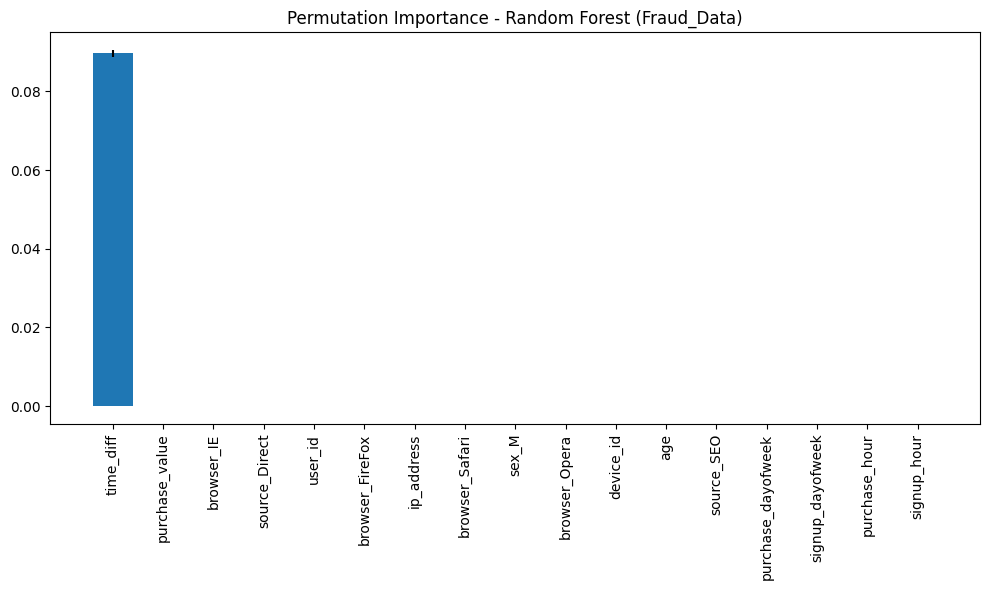


=== Logistic Regression (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.06      0.87      0.11        95

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746

ROC-AUC: 0.9245828335821638

=== Random Forest (CreditCard) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.72      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.86      0.91     56746
weighted avg       1.00      1.00      1.00     56746

ROC-AUC: 0.8578770849030397

=== XGBoost (CreditCard) ===


c:\Users\Amenzz\Desktop\week8\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:34:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.94      0.76      0.84        95

    accuracy                           1.00     56746
   macro avg       0.97      0.88      0.92     56746
weighted avg       1.00      1.00      1.00     56746

ROC-AUC: 0.8789032385733889


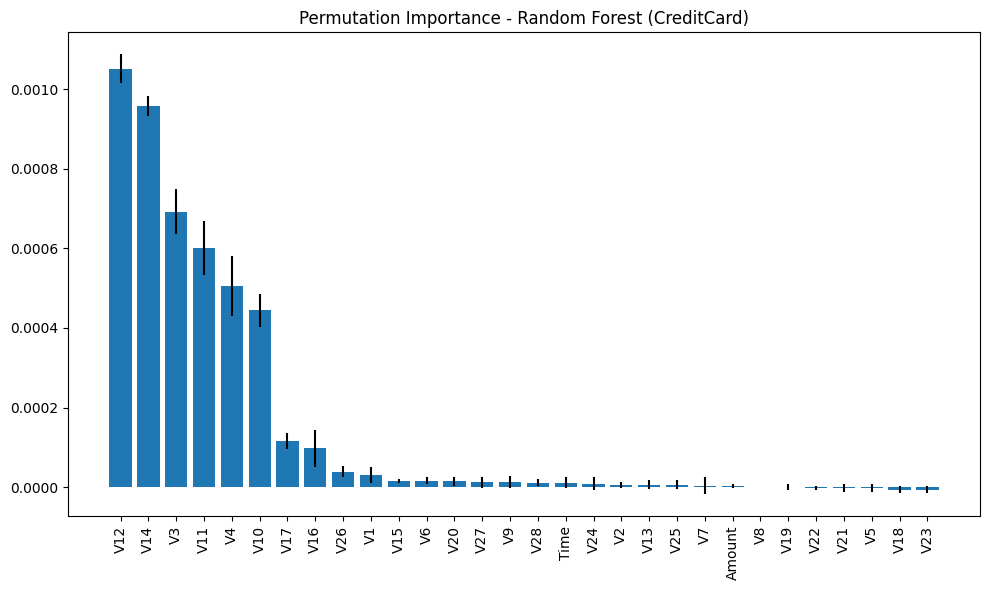

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def train_and_evaluate(X_train, X_test, y_train, y_test, dataset_name="Dataset"):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
        "XGBoost": XGBClassifier(
            n_estimators=200, learning_rate=0.1, max_depth=6,
            scale_pos_weight=10, random_state=42,
            use_label_encoder=False, eval_metric='logloss'
        )
    }

    results = {}

    for name, model in models.items():
        print(f"\n=== {name} ({dataset_name}) ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print(classification_report(y_test, y_pred))
        print("ROC-AUC:", roc_auc_score(y_test, y_pred))

        results[name] = model

    return results

def explain_model(model, X_test, y_test, feature_names, model_name, dataset_name):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Sort by importance
    sorted_idx = result.importances_mean.argsort()[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sorted_idx)), result.importances_mean[sorted_idx], yerr=result.importances_std[sorted_idx])
    plt.xticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.title(f"Permutation Importance - {model_name} ({dataset_name})")
    plt.tight_layout()
    plt.show()

fraud_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\Fraud_Data.csv')
fraud_df.dropna(inplace=True)
fraud_df.drop_duplicates(inplace=True)

# Datetime features
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['signup_dayofweek'] = fraud_df['signup_time'].dt.dayofweek
fraud_df['purchase_dayofweek'] = fraud_df['purchase_time'].dt.dayofweek
fraud_df['time_diff'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()
fraud_df.drop(['signup_time', 'purchase_time'], axis=1, inplace=True)

# One-hot encoding
fraud_df = pd.get_dummies(fraud_df, columns=['sex', 'source', 'browser'], drop_first=True)

# Features/Target
X_fraud = fraud_df.drop('class', axis=1)
y_fraud = fraud_df['class']
X_fraud = X_fraud.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train-test split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

# Scaling
scaler_fraud = StandardScaler()
X_fraud_train = scaler_fraud.fit_transform(X_fraud_train)
X_fraud_test = scaler_fraud.transform(X_fraud_test)

# Train models
fraud_models = train_and_evaluate(X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, "Fraud_Data")

# Explain best model (Random Forest or XGBoost usually best)
best_model_fraud = fraud_models["Random Forest"]
explain_model(best_model_fraud, X_fraud_test, y_fraud_test, X_fraud.columns, "Random Forest", "Fraud_Data")

credit_df = pd.read_csv(r'C:\Users\Amenzz\Desktop\week8\data\creditcard.csv')
credit_df.dropna(inplace=True)
credit_df.drop_duplicates(inplace=True)

# Features/Target
X_credit = credit_df.drop('Class', axis=1)
y_credit = credit_df['Class']
X_credit = X_credit.apply(pd.to_numeric, errors='coerce').fillna(0)

# Train-test split
X_credit_train, X_credit_test, y_credit_train, y_credit_test = train_test_split(
    X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit
)

# Scaling
scaler_credit = StandardScaler()
X_credit_train = scaler_credit.fit_transform(X_credit_train)
X_credit_test = scaler_credit.transform(X_credit_test)

# Train models
credit_models = train_and_evaluate(X_credit_train, X_credit_test, y_credit_train, y_credit_test, "CreditCard")

# Explain best model
best_model_credit = credit_models["Random Forest"]
explain_model(best_model_credit, X_credit_test, y_credit_test, X_credit.columns, "Random Forest", "CreditCard")
